<a href="https://colab.research.google.com/github/vlamen/tue-deeplearning/blob/main/assignments/assignment_1/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>    

# Group Number:37
# Student 1: Jiong Li | 1533312
# Student 2: Peter Elmers | 1734350
# Student 3: P.T.C.M. Tholhuijsen | 1237447

In [1]:
import requests
import io
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


### Training data set


For Assignment 1 you need to use a specific data set prepared using images from the [Omniglot dataset](https://github.com/brendenlake/omniglot). The provided training data set contains images of handwritten characters of size (28,28). 



For training data, the dataset contains 10000 sets of 6 images each. Each set consists of 5 support images and 1 query image. In each set, the first five columns are support images and the last one is a query image.

For training labels, the dataset contains 10000 sets of 5 binary flags for support images. 1 indicates the same character is given in the query image and 0 means not. For example, a label [1,0,0,1,1] means the support images with index 0,3,4 are the same character of query image.

 
 
The following cell provides code that loads the data from hardcoded URLs.You can use the code in this cell to load the dataset or download the data set from the given URLs to your local drive (or your Google drive) and modify the code to load the data from another location. 




In [2]:
def load_numpy_arr_from_url(url):
    """
    Loads a numpy array from surfdrive. 
    
    Input:
    url: Download link of dataset 
    
    Outputs:
    dataset: numpy array with input features or labels
    """
    
    response = requests.get(url)
    response.raise_for_status()

    return np.load(io.BytesIO(response.content)) 
    
    
    
#Downloading may take a while..
train_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/4OXkVie05NPjRKK/download')
train_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/oMLFw60zpFX82ua/download')

print(f"train_data shape: {train_data.shape}")
print(f"train_label shape: {train_label.shape}\n")

train_data shape: (10000, 6, 28, 28)
train_label shape: (10000, 5)



Now, we plot the first 5 cases in the training dataset. The last column corresponds with the query images of each task. All other images are support images. The image enclosed in a red box denotes the target image that your model should be able to recognize as the same class as the query image. 

In [3]:
def plot_case(caseID,train_data,labels):
    """
    Plots a single sample of the query dataset
    
    Inputs
    caseID: Integer between 0 and 99, each corresponding to a single sample in the query dataset 
    """
    

    support_set,queries = np.split(train_data, [5], axis=1)
    
    f, axes = plt.subplots(1, 6, figsize=(20,5))

    # plot anchor image
    axes[5].imshow(queries[caseID, 0])
    axes[5].set_title(f"Query image case {caseID}", fontsize=15)

    # show all test images images 
    [ax.imshow(support_set[caseID, i]) for i, ax in enumerate(axes[0:-1])]


    # Add the patch to the Axes
    for ind in np.where(labels[caseID]==True)[0]:
        axes[ind].add_patch(Rectangle((0,0),27,27,linewidth=2, edgecolor='r',facecolor='none'))


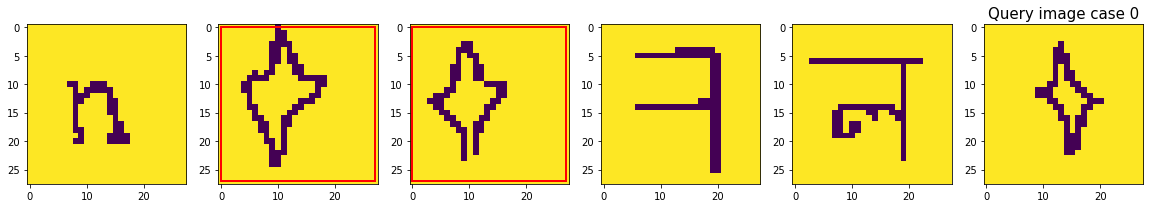

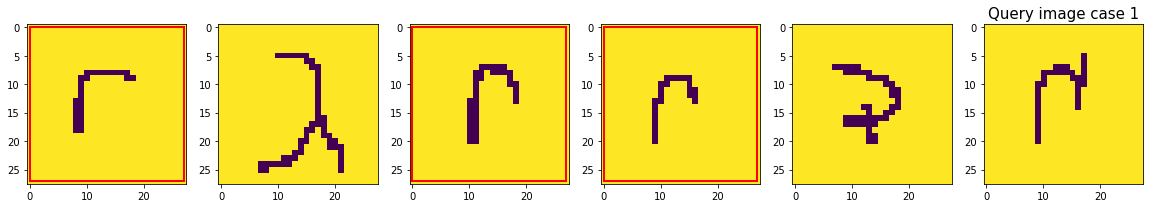

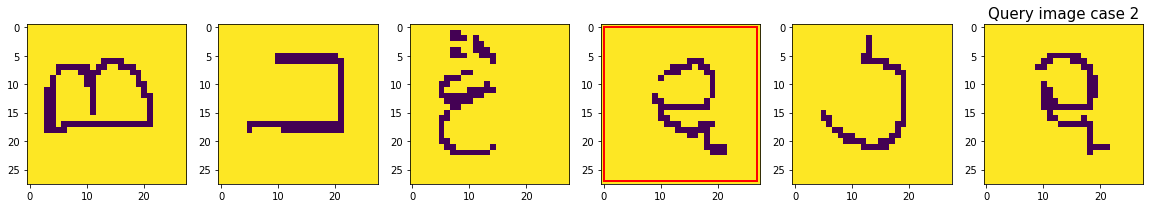

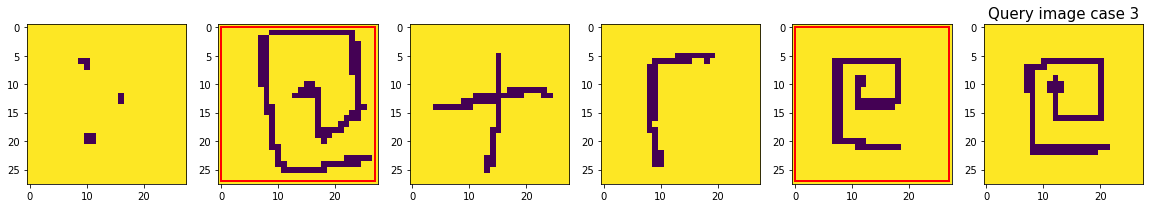

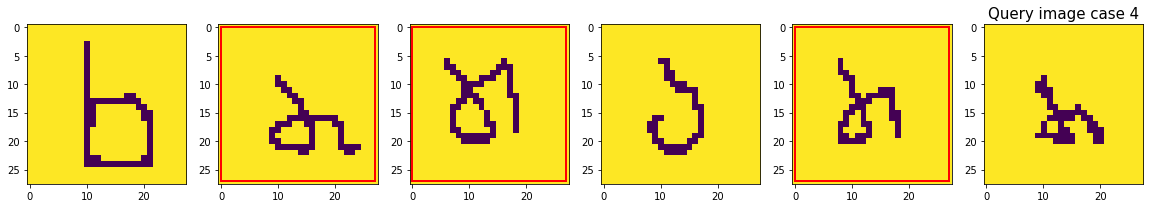

In [4]:
[plot_case(caseID,train_data,train_label) for caseID in range(5)] ;

### Query data set

For this task you need to use the following query data set. The dataset contains 1000 sets of 6 images each. The images are also of hand written characters, however these characters are not present in the training data set. The characters in the query data set all come from the Greek alphabet that is not part of the set of alphabets in the training data. 


In [5]:
    
#Downloading may take a while..
test_data = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/06c34QVUr69CxWY/download')
test_label = load_numpy_arr_from_url('https://surfdrive.surf.nl/files/index.php/s/LQIH1CW7lfDXevk/download')

print(f"test_data shape: {test_data.shape}")
print(f"test_label shape: {test_label.shape}\n")

test_data shape: (1000, 6, 28, 28)
test_label shape: (1000, 5)



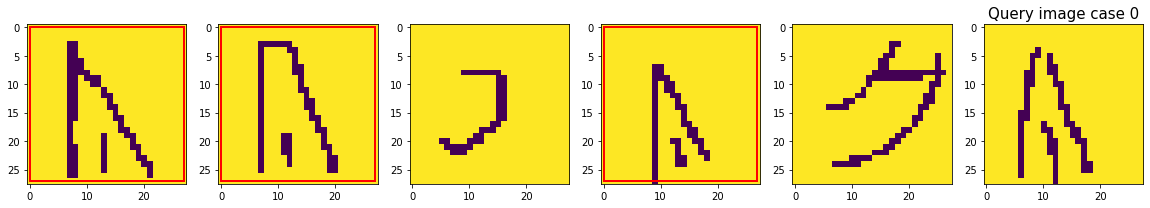

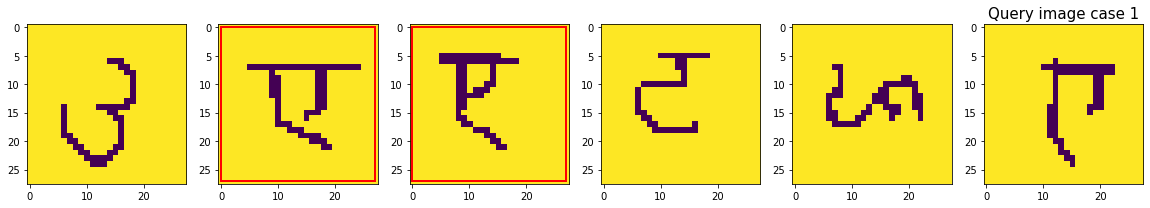

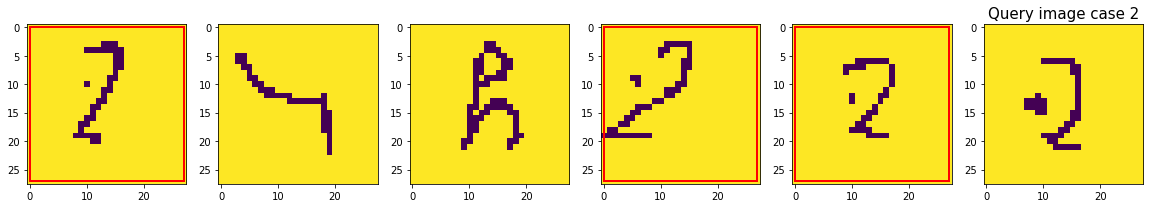

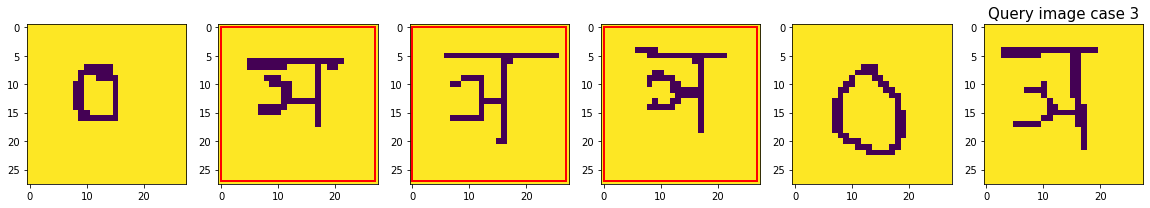

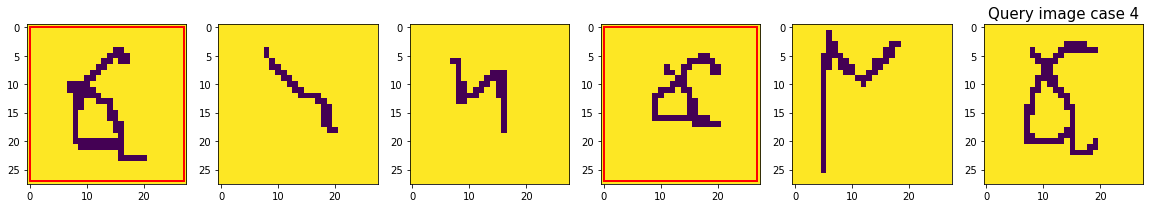

In [6]:
[plot_case(caseID,test_data,test_label) for caseID in range(5)] ;

### Build pytorch dataset and dataload

In [7]:
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader,TensorDataset
import numpy as np
from PIL import Image

class MyDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = torch.FloatTensor(data)
        self.targets = torch.LongTensor(targets)
        self.transform = transform

        
    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]
        return x, y
    
    def __len__(self):
        return len(self.data)

In [8]:
from sklearn.model_selection import train_test_split
train_data, validation_data, train_label, validation_label = train_test_split(train_data, train_label, test_size=0.2)

In [9]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize(0, 1)])
train_dataset=MyDataset(train_data,train_label, transform)
validation_dataset=MyDataset(validation_data,validation_label, transform)
test_dataset=MyDataset(test_data,test_label, transform)

In [10]:
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=10)
validation_loader = torch.utils.data.DataLoader(validation_dataset, batch_size=10)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=10)

In [11]:
# What is the data loader output shape?
x_example, y_example = next(iter(torch.utils.data.DataLoader(train_dataset, batch_size=10)))
x_example.shape, y_example.shape

(torch.Size([10, 6, 28, 28]), torch.Size([10, 5]))

In [28]:
import random
import matplotlib.pyplot as plt
import torchvision.transforms.functional as TF

# Fitting/Training the model
def random_rotate(img):
    angle = random.choice([0, 90, 180, 270])
    return TF.rotate(img, angle)

def make_triplets(imgs, yb):
    '''
    For each tuple of imgs, create triples of (anchor, positive, negative).
    One triple for each positive, negatives are chosen randomly.
    '''
    # N = batch size
    N = imgs.shape[0]
    anchors = []
    positives = []
    negatives = []
    # for each batch, get pos_yb and neg_yb. then for each positive, take a random negative
    for n in range(N):
        pos_yb = (yb[n, :] == 1).nonzero()
        neg_yb = (yb[n, :] == 0).nonzero()
        for pos_idx in pos_yb:
            # TODO: add data augmentation? by rotation
            anchors.append(imgs[n, -1].unsqueeze(0))
            # add 1 to the index because query is the first one
            positives.append(imgs[n, pos_idx])
            negatives.append(imgs[n, random.choice(neg_yb)])
            
    # Return N*r anchors, positives, negatives
    return [torch.cat(imgs) for imgs in [anchors, positives, negatives]]

def fit(epochs, loss_func, model, train_loader, val_loader, opt):
    threshold = 0.5
    loss_graph = []
    for epoch in range(epochs):
        model = model.train()
        print(f'Epoch {epoch + 1}')
        
        losses = []
        for imgs, yb in tqdm(train_loader, desc="Training"):
            opt.zero_grad()

            anchor, positive, negative = make_triplets(imgs, yb)
            # Then apply model to each of the three and use triplet loss: https://pytorch.org/docs/stable/generated/torch.nn.TripletMarginLoss.html(a, p, n)
            # http://www.bmva.org/bmvc/2016/papers/paper119/paper119.pdf
            if torch.cuda.is_available():
                anchor, positive, negative = [v.cuda() for v in [anchor, positive, negative]]
            
            anchor, positive, negative = [model(v) for v in [anchor, positive, negative]]
            
            loss = loss_func(anchor, positive, negative)

            # Backward and optimize
            loss.backward()
            opt.step()

            # Record data
            losses.append(loss.item() / anchor.shape[0])

        loss_graph.append(sum(losses) / len(train_loader))
        print(f'Average loss: {loss_graph[-1]}')

        print('Train accuracy:' f'{(threshold, test(model, train_loader, threshold))}')
        print('Validation accuracy:' f'{(threshold, test(model, val_loader, threshold))}')
        # threshold_range = list(torch.linspace(0, 1, 5))
        # print(
            # 'Validation accuracy by threshold:'
            # f'{[(t.item(), test(model, val_loader, t)) for t in tqdm(threshold_range, desc="Validating")]}')

    plt.plot(loss_graph)
    plt.title("training loss")
    plt.xlabel("epoch number")
    plt.ylabel("loss value")


# TODO: show a couple examples of make_triplets

In [27]:
def test(model, test_loader, threshold=0.5):
    '''
    Test given model using data from given loader with given threshold.
    Return scores: (FP, TP, accuracy)
    '''
    model = model.eval()
    running_tp = 0.0
    running_fp = 0.0
    running_acc = 0.0
    with torch.no_grad():
        for imgs, yb in test_loader:
            if torch.cuda.is_available():
                imgs = imgs.cuda()
                yb = yb.cuda()

            # Embed each img
            query = model(imgs[:, -1])
            supports = []
            for col in range(imgs.shape[1] - 1):
                embed = model(imgs[:, col])
                supports.append(embed)

            # Calculate euclidean/cosine distance from query to each support
            cos = nn.CosineSimilarity()
            # distances = torch.stack([((query - sup)**2).sum(axis=1).sqrt() for sup in supports]).T
            distances = torch.stack([0.5 - (cos(query, sup) / 2.) for sup in supports]).T
            # Classify based on given threshold: if support is closer than threshold, it is the same
            # softmax of euclidean distances: https://arxiv.org/pdf/1703.05175.pdf
            # ratio measure via softmax: https://arxiv.org/pdf/1412.6622.pdf
            preds = (distances < threshold).float()
            # Receiver operating characteristic plots the true and false positives
            running_tp += (((preds == 1) & (yb == 1)).sum() / (yb == 1).sum()).item()
            running_fp += (((preds == 1) & (yb == 0)).sum() / (yb == 0).sum()).item()
            running_acc += ((preds == yb).sum() / yb.shape[0] / yb.shape[1]).item()
            
        n = len(test_loader)
        return (running_fp / n, running_tp / n, running_acc / n)

def plot_roc(model, loader, thresholds, desc="Validation"):
    rocs = [test(model, loader, t) for t in thresholds]
    # Split tuples into x and y, x = FP and y = TP
    x = [roc[0] for roc in rocs]
    y = [roc[1] for roc in rocs]
    # z = accuracy, is not plotted
    z = [roc[2] for roc in rocs]
    plt.plot(x, y)
    plt.title(f"{desc} ROC")
    plt.xlabel("false positive rate")
    plt.ylabel("true positive rate")
    return x, y, z

In [14]:
from tqdm import tqdm
import torch.nn as nn
import torch.nn.functional as F

class OneModel(nn.Module):
    def __init__(self):
        super(OneModel, self).__init__()

    def forward(self, images):
        return torch.ones((images.shape[0], images.shape[1]))

class RandomModel(nn.Module):
    def __init__(self):
        super(RandomModel, self).__init__()

    def forward(self, images):
        return torch.randn((images.shape[0], images.shape[1]))

In [15]:
# The model

class Flatten(nn.Module):
    def forward(self, x):
        N = x.shape[0]
        return x.view(N, -1)

class Model(nn.Module):
    # Examples: https://github.com/MSiam/Few-Shot-Learning
    def __init__(self):
        super(Model, self).__init__()
        channels = [1, 16, 64, 128]
        embedding_length = 32

        # Image is N x 28 x 28, N = batch size
        self.embed = nn.Sequential(
            nn.Conv2d(channels[0], channels[1], 7, padding=3),
            nn.BatchNorm2d(channels[1]),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(channels[1], channels[2], 3, padding=1),
            nn.BatchNorm2d(channels[2]),
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(channels[2], channels[3], 3, padding=1),
            nn.BatchNorm2d(channels[3]),
            nn.ReLU(),
            Flatten(),
            nn.Linear(7 * 7 * channels[3], embedding_length)
        )

    def forward(self, x):
        if len(x.shape) == 3:
            x = x.unsqueeze(1)
        x = self.embed(x)
        return x

model = Model()
def count_parameters(model):
    temp = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f'The model architecture:\n\n', model)
    print(f'\nThe model has {temp:,} trainable parameters')
    
count_parameters(model)

The model architecture:

 Model(
  (embed): Sequential(
    (0): Conv2d(1, 16, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): ReLU()
    (8): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): Flatten()
    (12): Linear(in_features=6272, out_features=32, bias=True)
  )
)

The model has 285,088 trainable parameters


/var/folders/bj/xq0r65c15zscywj6dg01l4rr0000gn/T/ipykernel_93925/1979104940.py:40: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  temp = sum(p.numel() for p in model.parameters() if p.requires_grad)


OneModel stats
Train accuracy: (1.0, 1.0, 0.3999999951571226)
Validation accuracy: (1.0, 1.0, 0.39939999505877494)
Test accuracy: (1.0, 1.0, 0.38859999418258667)


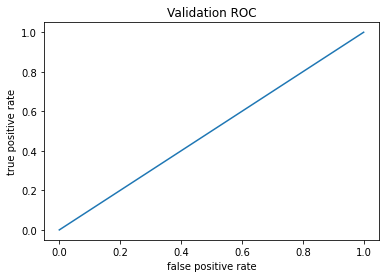

In [16]:
# Baseline: a model that always predicts 1 (same category for all support images)
print('OneModel stats')
print(f"Train accuracy: {test(OneModel(), train_loader, 0.5)}")
print(f"Validation accuracy: {test(OneModel(), validation_loader, 0.5)}")
print(f"Test accuracy: {test(OneModel(), test_loader, 0.5)}")

_ = plot_roc(OneModel(), validation_loader, torch.linspace(0, 1, 10))

Random model stats
Train accuracy: (0.49869715709239243, 0.5044097792357206, 0.5023000022768974)
Validation accuracy: (0.495447219312191, 0.501043611317873, 0.5035000009834767)
Test accuracy: (0.49347581297159193, 0.4886303597688675, 0.5000000014901161)


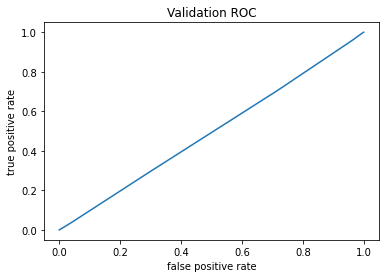

In [17]:
print('Random model stats')
print(f"Train accuracy: {test(RandomModel(), train_loader, 0.5)}")
print(f"Validation accuracy: {test(RandomModel(), validation_loader, 0.5)}")
print(f"Test accuracy: {test(RandomModel(), test_loader, 0.5)}")

_ = plot_roc(RandomModel(), validation_loader, torch.linspace(0, 1, 10))

Epoch 1


Training: 100%|██████████| 800/800 [00:25<00:00, 31.10it/s]


Average loss: 0.023021469084472446
Train accuracy:(0.5, (0.5082390772365034, 0.9807507777959108, 0.6874999940395355))
Validation accuracy:(0.5, (0.5255603611469268, 0.9816895380616188, 0.6766999965906143))
Epoch 2


Training: 100%|██████████| 800/800 [00:25<00:00, 31.74it/s]


Average loss: 0.016903140047597246
Train accuracy:(0.5, (0.5228265996463597, 0.994005729034543, 0.6839999967068434))
Validation accuracy:(0.5, (0.5367699778825045, 0.9950536099076271, 0.6748999974131584))
Epoch 3


Training: 100%|██████████| 800/800 [00:26<00:00, 30.65it/s]


Average loss: 0.014808536593310846
Train accuracy:(0.5, (0.4774983564205468, 0.9964256121963263, 0.7120499956607819))
Validation accuracy:(0.5, (0.4971639237180352, 0.996331870853901, 0.6996999964118004))
Epoch 4


Training: 100%|██████████| 800/800 [00:26<00:00, 30.00it/s]


Average loss: 0.013508503574918207
Train accuracy:(0.5, (0.47611403338611125, 0.9977358278632164, 0.7134499944746494))
Validation accuracy:(0.5, (0.5042264295369386, 0.9978101179003716, 0.6959999963641167))
Epoch 5


Training: 100%|██████████| 800/800 [00:26<00:00, 29.95it/s]


Average loss: 0.012727947800849779
Train accuracy:(0.5, (0.4850036318786442, 0.9985227036476135, 0.7081999955326319))
Validation accuracy:(0.5, (0.5174692771583795, 0.9975022959709168, 0.6877999979257584))
Epoch 6


Training: 100%|██████████| 800/800 [00:30<00:00, 26.53it/s]


Average loss: 0.01167278253185361
Train accuracy:(0.5, (0.475431843418628, 0.9988525208085776, 0.7140999948978424))
Validation accuracy:(0.5, (0.5239719408750534, 0.9974466982483864, 0.6838999971747398))
Epoch 7


Training: 100%|██████████| 800/800 [00:30<00:00, 25.96it/s]


Average loss: 0.01113237780398109
Train accuracy:(0.5, (0.4676110507082194, 0.9993960002809763, 0.7190749955922365))
Validation accuracy:(0.5, (0.5169831675291061, 0.9984932318329811, 0.6882999968528748))
Epoch 8


Training: 100%|██████████| 800/800 [00:47<00:00, 16.79it/s]


Average loss: 0.010609391855646147
Train accuracy:(0.5, (0.44385704919695856, 0.9994789696484804, 0.7332249949127436))
Validation accuracy:(0.5, (0.49902824707329274, 0.9984670063853264, 0.6992999961972237))
Epoch 9


Training: 100%|██████████| 800/800 [00:42<00:00, 18.65it/s]


Average loss: 0.010027319531087521
Train accuracy:(0.5, (0.42813703153282406, 0.99958247423172, 0.7425749957561493))
Validation accuracy:(0.5, (0.4982943447679281, 0.9987491428852081, 0.6996999952197075))
Epoch 10


Training: 100%|██████████| 800/800 [00:45<00:00, 17.74it/s]


Average loss: 0.009686815442646702
Train accuracy:(0.5, (0.42218074142932893, 0.999509244337678, 0.7460499966144561))
Validation accuracy:(0.5, (0.49982340149581433, 0.9981676641106606, 0.6987999969720841))


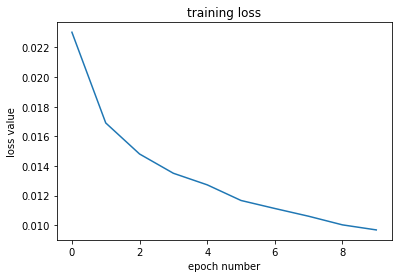

In [29]:
model = Model()

threshold = 1
loss_func = nn.TripletMarginWithDistanceLoss(
    distance_function=lambda x,y: 1. - F.cosine_similarity(x, y), margin=threshold)

if torch.cuda.is_available():
    model = model.cuda()
    loss_func = loss_func.cuda()

# The optimizer
from torch.optim import AdamW, SGD

# optimizer = AdamW(model.parameters(), lr=1e-3, weight_decay=0.005)
optimizer = SGD(model.parameters(), lr=1e-3, momentum=0.9)

epochs = 10
fit(epochs, loss_func, model, train_loader, validation_loader, optimizer)

Max accuracy: 0.6832999970018864


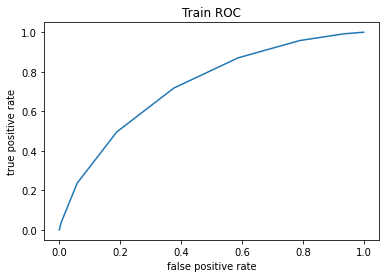

In [23]:
results = plot_roc(model, train_loader, torch.linspace(0, 1, 10), desc="Train")
print(f'Max accuracy: {max(results[2])}')

Max accuracy: 0.9242999827861786


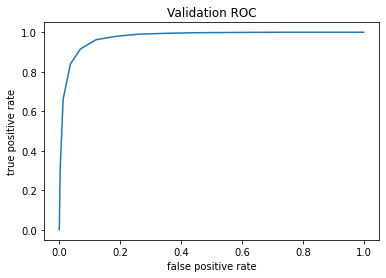

In [30]:
# Search for a good threshold on the validation set
threshold_search = list(torch.linspace(0, 1, 20))
fps, tps, accs = plot_roc(model, validation_loader, threshold_search, desc="Validation")
print(f'Max accuracy: {max(accs)}')

In [31]:
# The best point is the one closest to (0, 1) on the fp/tp curve
qualities = [1 - (fp ** 2 + (1 - tp) ** 2) for fp, tp in zip(fps, tps)]
best_threshold = threshold_search[max(range(len(qualities)), key=lambda i: qualities[i])]
print(f'Best threshold is {best_threshold}')
res = test(model, test_loader, best_threshold)
print(f'FP/TP/acc is {res}')

Best threshold is 0.21052631735801697
FP/TP/acc is (0.0652375015616417, 0.881723638176918, 0.913599978685379)
